In [1]:
%pylab inline
import os
import scipy
import pyiga as iga
from pyiga import geometry, assemble, vis 
import pandas as pd
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


Solve subharmonic PDE 
$$
\begin{split}
    \Delta u = 1 & \quad \text{ in } \Omega = (0,1)^2 \\
    u = 0 & \quad \text{ on } \partial \Omega
\end{split}
$$

In [2]:
f = lambda x,y: 1. #unity source term
g = lambda x,y: 0. #zero boundary conditions

True solution given by Fourier expansion
$$
    u(x,y) = \sum_{n,m \in \mathbb{N}}
            b_{n,m} \sin(n\pi x)\sin(m\pi y)
    \qquad \text{with} \qquad
    b_{n,m} = \begin{cases}
        \frac{16}{\pi^4 nm(n^2+m^2)} & \text{ if } n,m \text{ are odd}\\
        0 & \text{otherwise }
    \end{cases}
$$

In [3]:
#vectorized
#caveat: raises memory error if fourier modes are too high!
def _true_solution_vectorized(x,y, n_fourier=100, grad=False):
    
    #coefficients of indicator function
    b = zeros(n_fourier)
    n = arange(1, n_fourier, 2)
    b = 4 / (pi * n )
    b =(b[:,None] * b[None,:]) / (pi**2 * (n[:,None]**2 + n[None,:]**2) )
    
    #broadcast
    nx = n[None,None,:,None]
    ny = n[None,None,None,:]
    b = b[None,None,:,:]
    x = x[:,:,None,None]
    y = y[:,:,None,None]
    
    #evaluate sine basis
    s1 = sin(pi * nx * x)
    s2 = sin(pi * ny * y)
    s = s1 * s2
    
    #evaluate cosine basis
    if grad:
        c1 = pi * nx * cos(pi * nx * x)
        c2 = pi * ny * cos(pi * ny * y)
        d1s = c1 * s2
        d2s = s1 * c2
    
    #linearly combine basis vectors
    u = s*b
    shape = u.shape
    u = sum(u, axis=3)
    u = sum(u, axis=2)
    if not grad: return u
    
    #linearly combine derivative
    du = zeros((2, *d1s.shape))
    du[0,:,:,:,:] = d1s * b
    du[1,:,:,:,:] = d2s * b
    du = sum(du, axis=4)
    du = sum(du, axis=3)
    return u, du


In [4]:
#looped
#caveat: very slow due to nested for loops
def _true_solution_looped(x,y, n_fourier=1000, grad=False, verbose=False):
    z = zeros_like(x+y)
    grad_z = zeros((2, *z.shape))
    
    #evaluate basis
    modes = arange(1, n_fourier, 2)
    if verbose: modes = tqdm(modes, desc="Fourier modes")
    for nx in modes:
        s1 = sin(pi * nx * x)
        if grad: c1 = pi * nx * cos(pi * nx * x)
        for ny in arange(1, n_fourier, 2):
            s2 = sin(pi * ny * y)
            if grad: c2 = pi * ny * cos(pi * ny * y)
            
            s = s1 * s2
            if grad: 
                d1s = c1 * s2
                d2s = s1 * c2
            
            #calculate coefficients
            b = 16 / ( pi**4 * nx*ny *(nx**2 + ny**2))
            z += b * s
            
            if grad:
                grad_z[0,:,:] += b*d1s
                grad_z[1,:,:] += b*d2s
    
    return z if not grad else (z,grad_z)

In [5]:
#true_solution = lambda x,y: _true_solution_vectorized(x,y, n_fourier=500, grad=True)
true_solution = lambda x,y: _true_solution_looped(x,y, n_fourier=1000, grad=True)

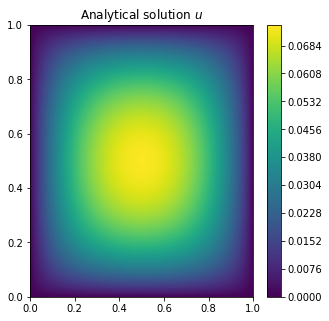

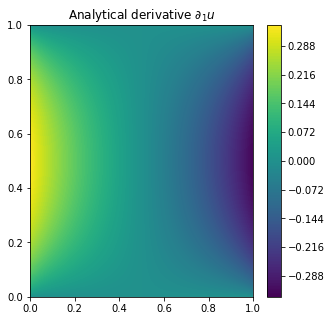

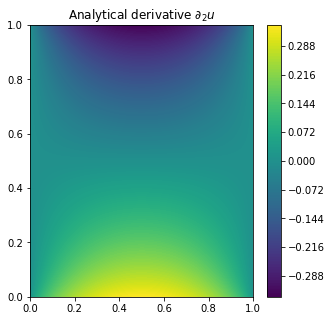

In [6]:
t = linspace(0,1,100), linspace(0,1,100)
x,y = meshgrid(*t)
z_true, grad_z_true = true_solution(x,y)


figsize(5,5)
levels, cmap = 200,'viridis'

title("Analytical solution $u$")
contourf(x,y,z_true, levels=200, cmap=cmap)
colorbar()
show()
title("Analytical derivative $\\partial_1 u$")
contourf(x,y,grad_z_true[0,:,:], levels=200, cmap=cmap)
colorbar()
show()
title("Analytical derivative $\\partial_2 u$")
contourf(x,y,grad_z_true[1,:,:], levels=200, cmap=cmap)
colorbar()
show()


In [7]:
def l2_error(u):
    z = u.grid_eval(t)
    l2e = (z - z_true)**2
    l2e = sum(l2e) / sum(z_true**2)
    l2e = sqrt( l2e )
    return l2e

def h1_error(u):
    grad_z = u.grid_jacobian(t)
    h1e = grad_z - grad_z_true.transpose((1,2,0))
    h1e = h1e**2
    h1e = sum(h1e) / sum(grad_z_true**2)
    h1e = sqrt(h1e)
    return h1e

In [8]:
def solve_problem(degree=2, subdivisions=10, mult=1, analysis=False):
    square = iga.geometry.unit_square()
    
    #refinement
    knots = iga.bspline.make_knots(degree, 0,1, subdivisions, mult)
    knots = (knots, knots)
    
    #Boundary conditions
    bcs = iga.assemble.compute_dirichlet_bcs(knots, square, 
            [["left", g], ["right", g], ["top", g], ["bottom", g]])

    #Assemble system
    L = iga.assemble.inner_products(knots, f, f_physical=True, geo=square).ravel()
    A = iga.assemble.stiffness(knots, square)
    system = iga.assemble.RestrictedLinearSystem(A, L, bcs)

    #Use sparse solver 
    u = scipy.sparse.linalg.spsolve(system.A, system.b)
    u_func = iga.geometry.BSplineFunc(knots, system.complete(u))
    if not analysis: return u_func
    
    #Optional: Store data for analysis
    data = dict()
    
    #h = (knots[0].meshsize_avg(), knots[1].meshsize_avg())
    h = unique(knots[0].kv), unique(knots[1].kv)
    h = max(h[0][1:]-h[0][:-1]), max(h[1][1:]-h[1][:-1])
    
    degree = (knots[0].p, knots[1].p)
    dof = iga.bspline.numdofs(knots)
    l2e = l2_error(u_func)
    h1e = h1_error(u_func)
    
    data['p'] = degree
    data['h'] = h
    data['nz'] = A.nnz
    data['dof'] = dof
    data['l2e'] = l2e
    data['h1e'] = h1e
    data['m'] = m
    return u_func, data

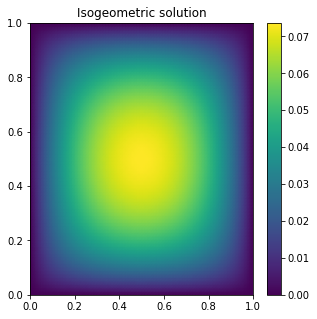

L2-error:  0.0004139666262531177
H1-error:  0.006426280241920838


In [9]:
u = solve_problem()

figsize(5,5)
title("Isogeometric solution")
square = iga.geometry.unit_square()
iga.vis.plot_field(u, square)
colorbar()
plt.show()

print("L2-error: ", l2_error(u))
print("H1-error: ", h1_error(u))

In [10]:
measurements = pd.DataFrame()
for p in tqdm(range(1,5), desc="degree"):
    for s in [i for i in range(1,10)] +[20, 30, 40, 50, 100, 150, 200]:
        for m in [1, p]:
            
            solution, data = solve_problem(
                degree=p,
                subdivisions=s,
                mult=m, 
                analysis=True)
            data = {k:data[k] for k in data}
            data = pd.DataFrame.from_dict(data)
            measurements = measurements.append(data) 

degree: 100%|██████████| 4/4 [02:38<00:00, 39.74s/it]


In [11]:
comparisons = dict()
directory = 'data'
for f in os.listdir(directory):
    name, ext = os.path.splitext(f) 
    if ext == ".csv":
        if  "harmonic" in name: 
            degree = int( name.split("_p")[-1] )

            print("Found data file '%s' for degree p=%d" % (f,degree))
            data = pd.read_csv(os.path.join(directory, f))
            comparisons[degree]  = data

Found data file 'superharmonic_juafem_p1.csv' for degree p=1
Found data file 'superharmonic_juafem_p2.csv' for degree p=2


In [12]:
comparisons
measurements

p         h        nz     dof           l2e       h1e  m
0   1  1.000000        16       4  1.000000e+00  1.000000  1
1   1  1.000000        16       4  1.000000e+00  1.000000  1
0   1  1.000000        16       4  1.000000e+00  1.000000  1
1   1  1.000000        16       4  1.000000e+00  1.000000  1
0   1  0.500000        49       9  3.289371e-01  0.578530  1
.. ..       ...       ...     ...           ...       ... ..
1   4  0.006667  12967201  361201  1.111469e-08  0.000212  4
0   4  0.005000   3297856   41616  1.118416e-08  0.000212  1
1   4  0.005000   3297856   41616  1.118416e-08  0.000212  1
0   4  0.005000  23049601  641601  1.111718e-08  0.000212  4
1   4  0.005000  23049601  641601  1.111718e-08  0.000212  4

[256 rows x 7 columns]

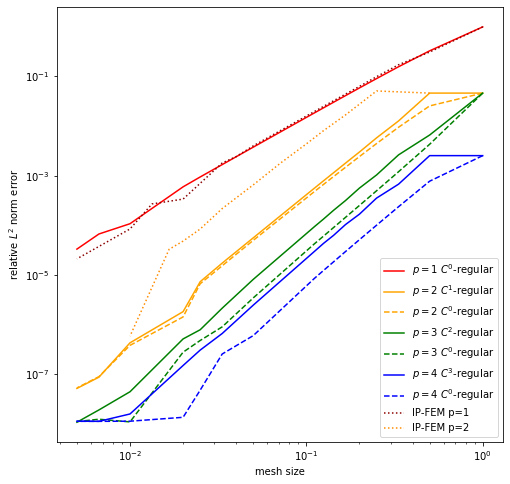

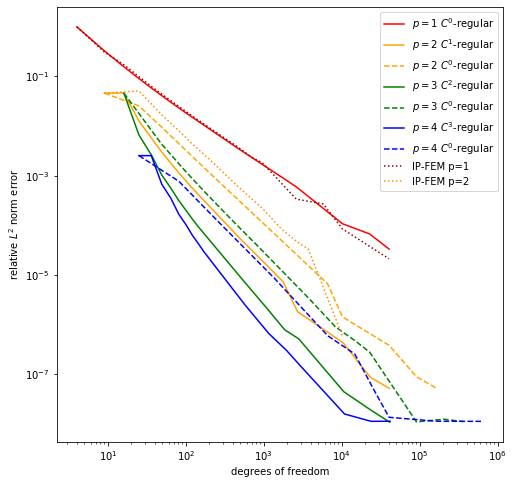

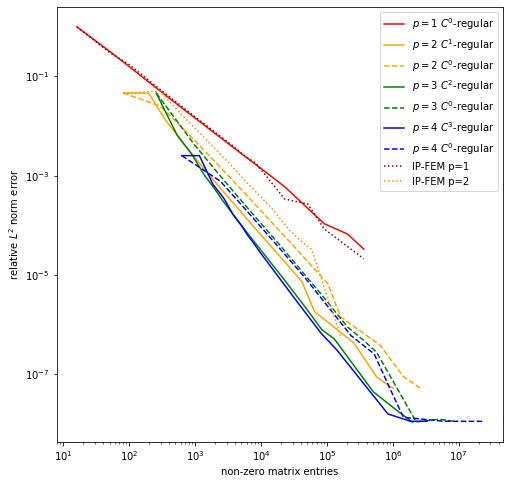

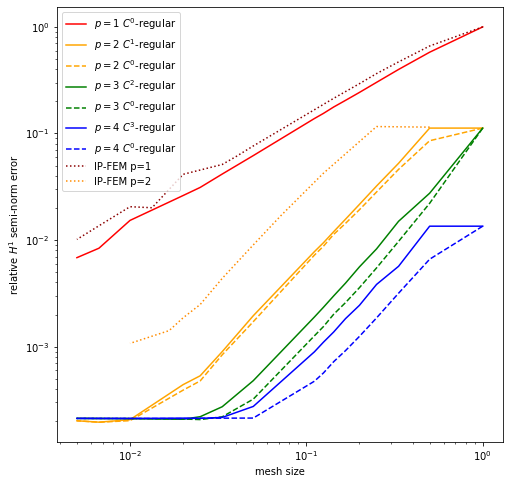

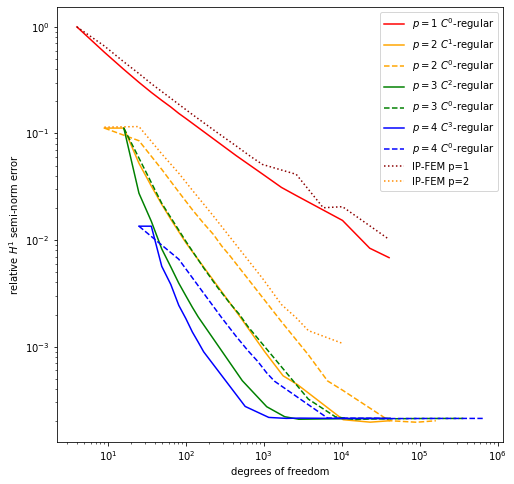

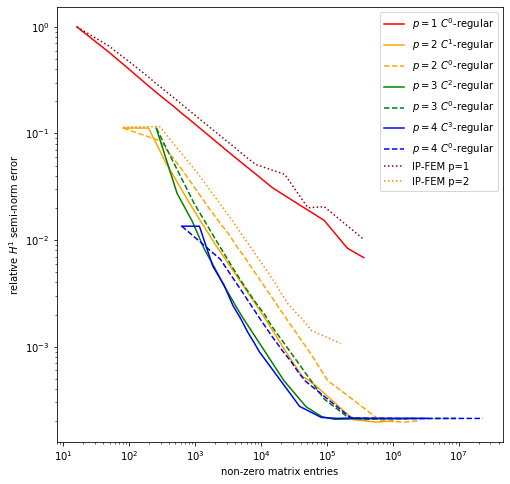

In [13]:
degrees = unique(measurements['p'])
mults = unique(measurements['m'])

figsize(8,8)
axes = { #quantities
    'h': 'mesh size',
    'dof': "degrees of freedom",
    'nz': 'non-zero matrix entries'
}
colors = { #colorize degree 
    1: 'red',
    2: 'orange',
    3: 'green',
    4: 'blue',
    5: 'purple'
}
styles = { #depict regularity with line style
    "C0" : '--',
    "Cp" : '-'
}
errors = {
    "l2e" : "relative $L^2$ norm error",
    "h1e" : "relative $H^1$ semi-norm error"
}
for e in errors:
    for q in axes:
        for p in degrees:
            for m in unique([1,p]):

                i = (measurements['p'] == p) & (measurements['m'] == m)
                err = measurements[e][i]
                v = measurements[q][i]

                label = "$p=%d$ " % p
                label += "$C^%d$" % (p-1) if m==1 else "$C^0$"
                label += "-regular"
                style = styles["Cp" if m==1 else "C0"]
                plot(v,err, label=label, c=colors[p], linestyle=style)

        for p in comparisons:
            data = comparisons[p]
            v = data[q]
            err = data[e]
            label = "IP-FEM p=%d" % p
            color = 'dark' + colors[p]
            plot(v, err, label=label, c=color, linestyle=':')

        legend()
        loglog()
        xlabel(axes[q])
        ylabel(errors[e])
        savefig('imgs/superharmonic.%s_vs_%s.png' % (q,e))
        show()